In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11954add0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f748650>]], dtype=object)

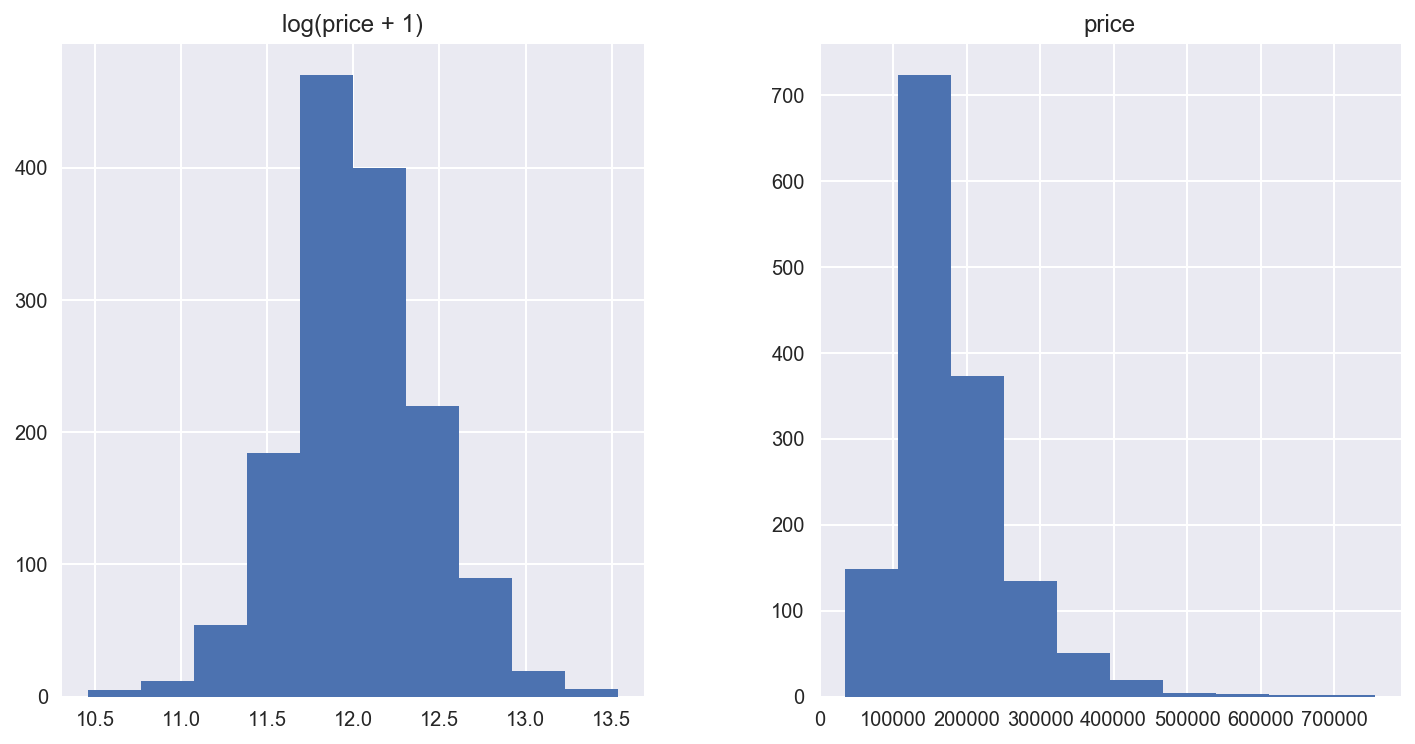

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [8]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [9]:
all_data = pd.get_dummies(all_data)

In [10]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [11]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice


In [12]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [13]:
model_ridge = Ridge()


In [14]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

In [15]:
cv_ridge

[0.13893637694024535,
 0.13777538277187873,
 0.13501433618086045,
 0.1313618498939956,
 0.12864892446111881,
 0.12782179689257298,
 0.12733734668670776,
 0.12752940439753813,
 0.12895888148450041,
 0.13099437857191421,
 0.13316366423370268]

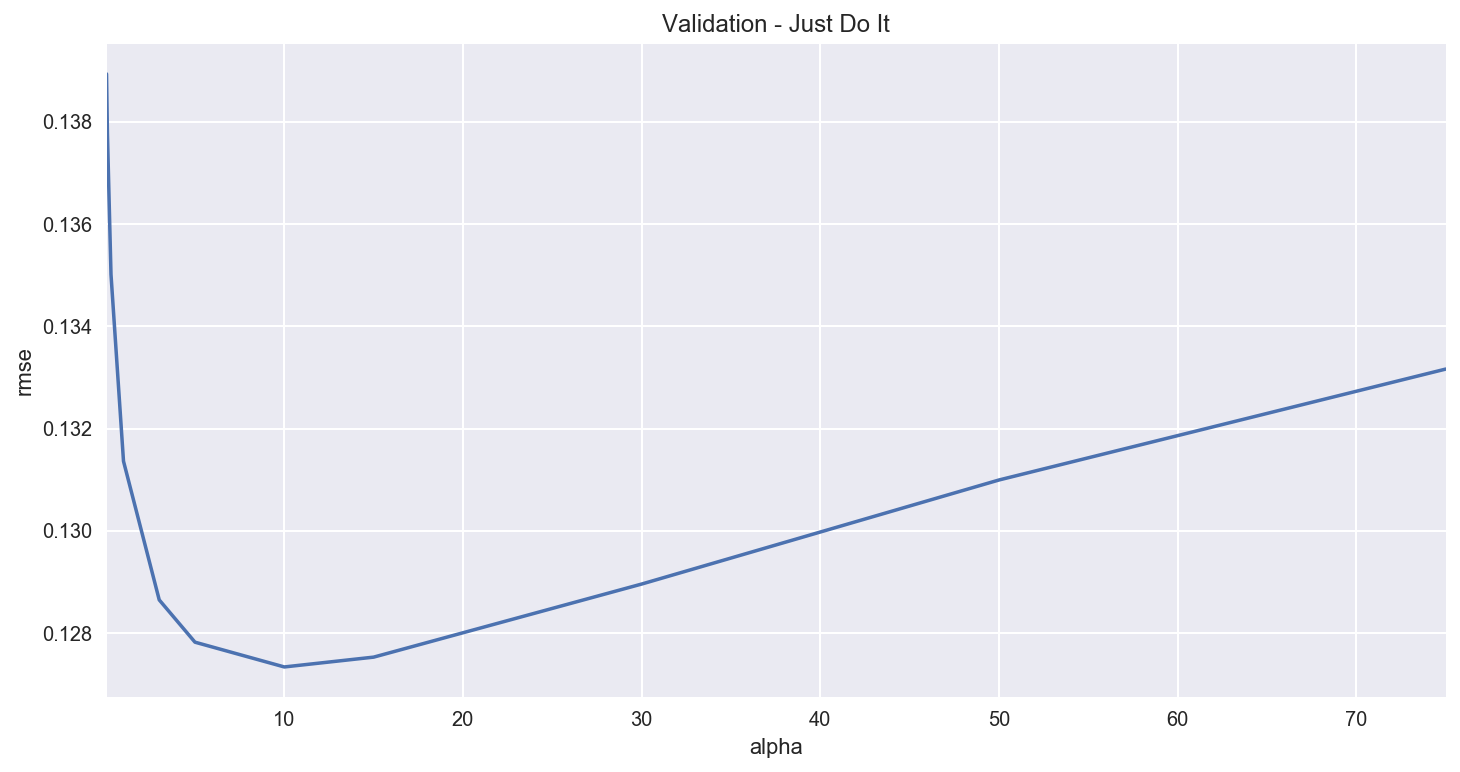

In [16]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [18]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [19]:
rmse_cv(model_lasso).mean()

0.12314421090977432

In [20]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [21]:
coef

MSSubClass              -0.007480
LotFrontage              0.000000
LotArea                  0.071826
OverallQual              0.053160
OverallCond              0.043027
YearBuilt                0.001777
YearRemodAdd             0.000722
MasVnrArea              -0.000194
BsmtFinSF1               0.009292
BsmtFinSF2              -0.001385
BsmtUnfSF               -0.003975
TotalBsmtSF              0.019208
1stFlrSF                 0.030350
2ndFlrSF                -0.003396
LowQualFinSF            -0.003880
GrLivArea                0.400009
BsmtFullBath             0.025674
BsmtHalfBath             0.000000
FullBath                 0.021307
HalfBath                 0.013793
BedroomAbvGr            -0.001004
KitchenAbvGr            -0.009937
TotRmsAbvGrd             0.005079
Fireplaces               0.022117
GarageYrBlt              0.000029
GarageCars               0.038789
GarageArea               0.000051
WoodDeckSF               0.004409
OpenPorchSF              0.001631
EnclosedPorch 

In [22]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [23]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [24]:
imp_coef

RoofMatl_ClyTile        -0.704161
MSZoning_C (all)        -0.292023
Condition2_PosN         -0.190552
Neighborhood_Edwards    -0.052560
SaleCondition_Abnorml   -0.047116
MSZoning_RM             -0.037698
CentralAir_N            -0.035440
GarageCond_Fa           -0.031688
LandContour_Bnk         -0.030934
SaleType_WD             -0.030656
OverallQual              0.053160
KitchenQual_Ex           0.063709
Exterior1st_BrkFace      0.070464
Neighborhood_NridgHt     0.071620
LotArea                  0.071826
Functional_Typ           0.072597
Neighborhood_NoRidge     0.085717
Neighborhood_Crawfor     0.105138
Neighborhood_StoneBr     0.112493
GrLivArea                0.400009
dtype: float64

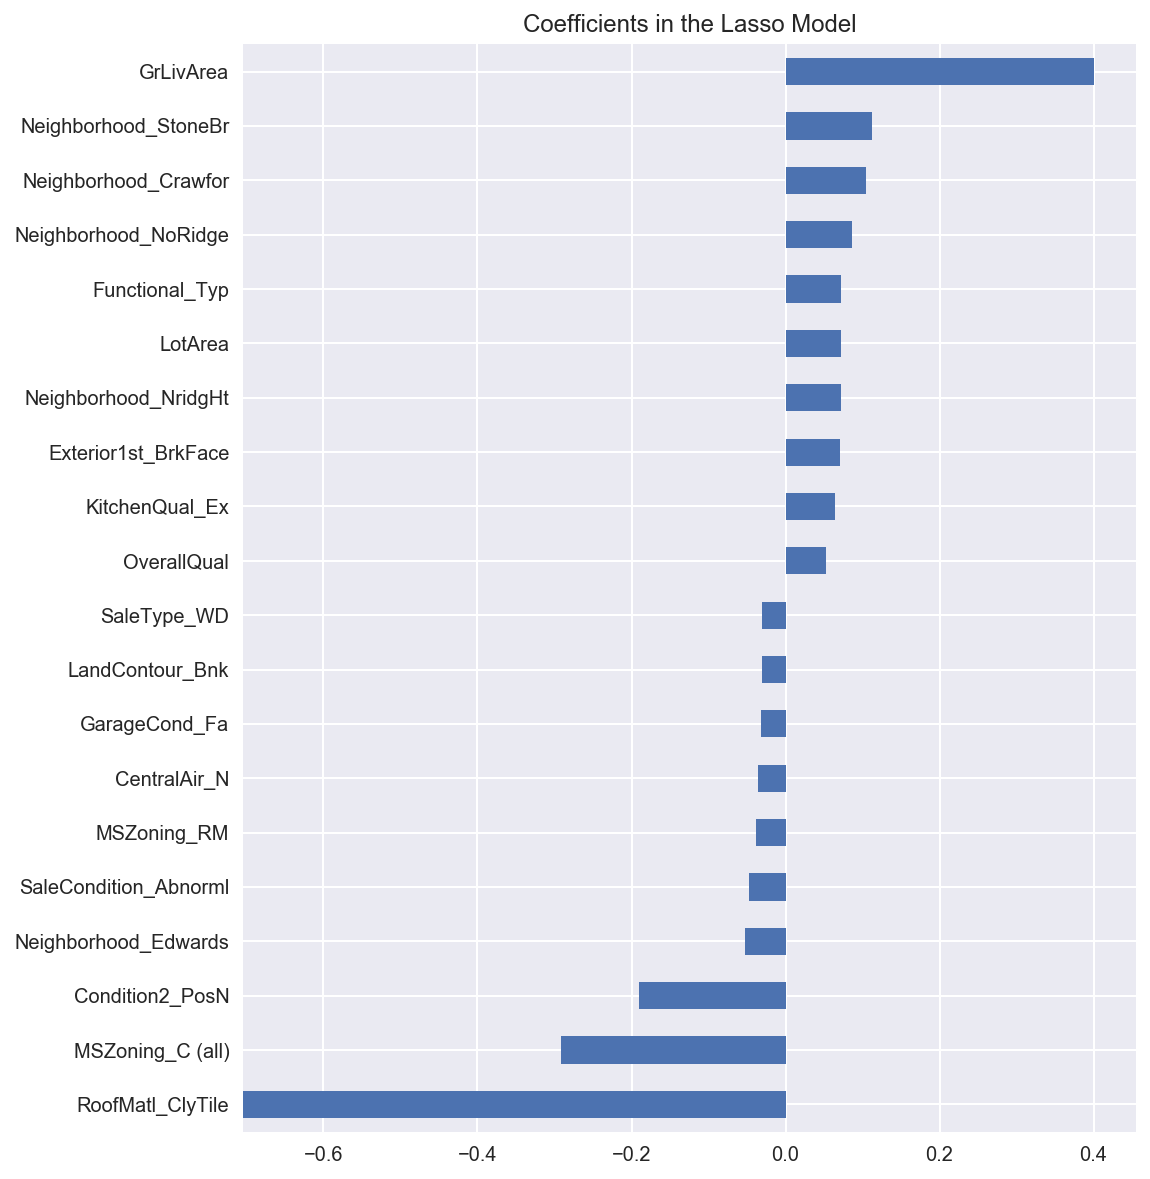

In [25]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

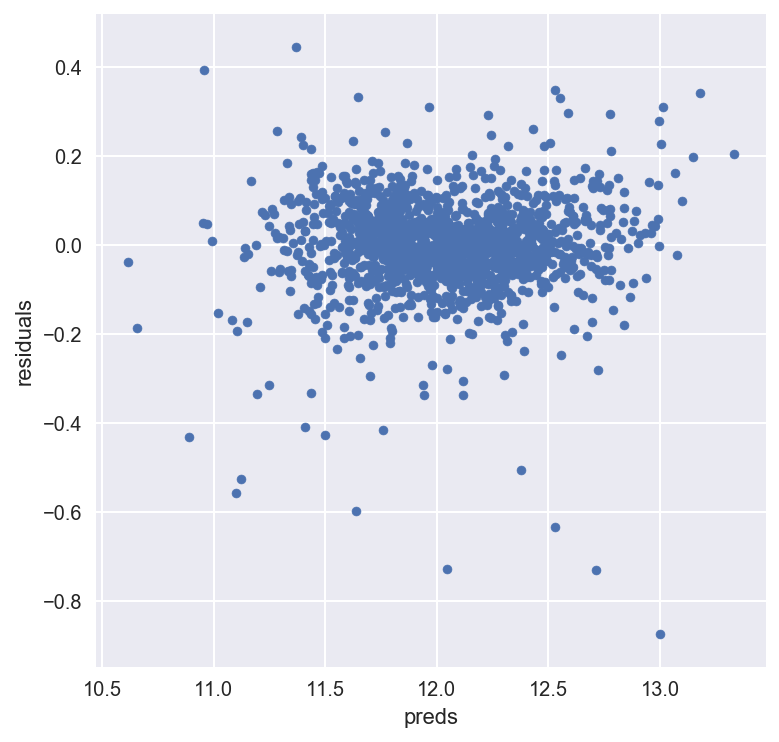

In [27]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")


/Users/songwei/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


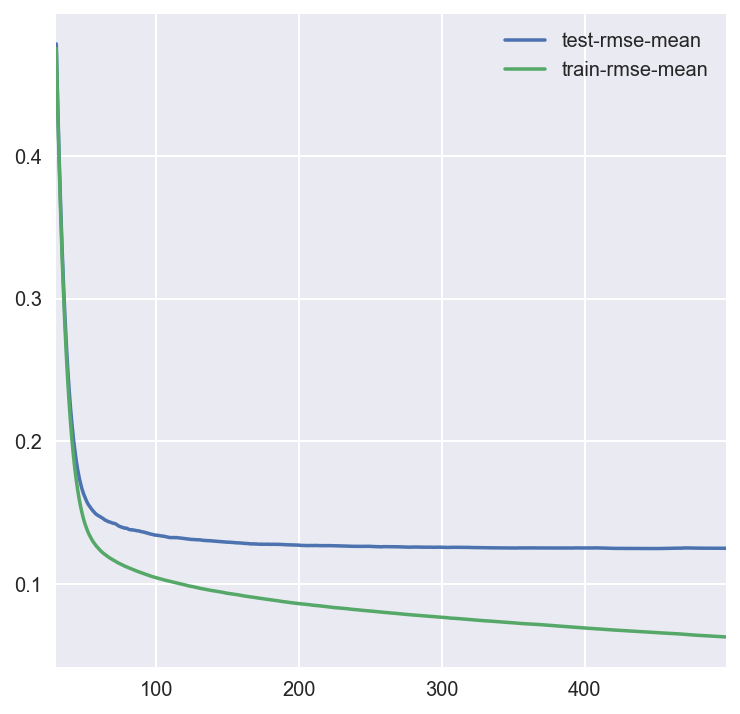

In [29]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()


In [30]:
model

test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0         10.380138       0.007834        10.380139        0.003413
1          9.344810       0.008219         9.344813        0.003153
2          8.413089       0.008584         8.413092        0.002927
3          7.574992       0.008599         7.574618        0.002707
4          6.820292       0.008262         6.819935        0.002493
5          6.140506       0.008449         6.140691        0.002305
6          5.529961       0.007377         5.529318        0.002142
7          4.979716       0.007123         4.979067        0.001986
8          4.484609       0.007024         4.483856        0.001864
9          4.039001       0.006651         4.038170        0.001760
10         3.637682       0.005868         3.637066        0.001683
11         3.276401       0.005339         3.276103        0.001623
12         2.952090       0.005279         2.951290        0.001555
13         2.659445       0.005625         2.658947        0.001494
14         2.396047       0.005122         2.395839        0.001426
15         2.158821       0.005102         2.159070        0.001386
16         1.946302       0.004815         1.945998        0.001316
17         1.754639       0.004822         1.754276        0.001276
18         1.581945       0.004825         1.581789        0.001236
19         1.426453       0.004696         1.426572        0.001253
20         1.286917       0.004503         1.286938        0.001203
21         1.161458       0.004734         1.161433        0.001230
22         1.048924       0.004797         1.048586        0.001227
23         0.947953       0.004584         0.947107        0.001253
24         0.857179       0.004350         0.855927        0.001307
25         0.775706       0.004628         0.774042        0.001398
26         0.702224       0.004760         0.700602        0.001457
27         0.637029       0.004989         0.634746        0.001515
28         0.578067       0.005160         0.575650        0.001589
29         0.525457       0.005231         0.522764        0.001671
..              ...            ...              ...             ...
470        0.125233       0.011347         0.064675        0.002140
471        0.125253       0.011391         0.064575        0.002183
472        0.125231       0.011375         0.064474        0.002205
473        0.125222       0.011349         0.064374        0.002226
474        0.125214       0.011357         0.064303        0.002236
475        0.125157       0.011367         0.064252        0.002207
476        0.125155       0.011372         0.064191        0.002172
477        0.125158       0.011375         0.064128        0.002169
478        0.125149       0.011395         0.064070        0.002149
479        0.125149       0.011402         0.064002        0.002140
480        0.125097       0.011412         0.063925        0.002165
481        0.125071       0.011410         0.063905        0.002164
482        0.125041       0.011394         0.063796        0.002141
483        0.125059       0.011424         0.063711        0.002128
484        0.125064       0.011459         0.063666        0.002106
485        0.125054       0.011465         0.063621        0.002099
486        0.125078       0.011435         0.063579        0.002102
487        0.125088       0.011417         0.063532        0.002106
488        0.125074       0.011380         0.063458        0.002104
489        0.125099       0.011366         0.063423        0.002108
490        0.125084       0.011356         0.063377        0.002131
491        0.125077       0.011353         0.063322        0.002134
492        0.125034       0.011320         0.063249        0.002131
493        0.125021       0.011327         0.063179        0.002154
494        0.125010       0.011324         0.063119        0.002139
495        0.125025       0.011332         0.063074        0.002118
496        0.125002       0.011342         0.063025        0.

In [31]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [32]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

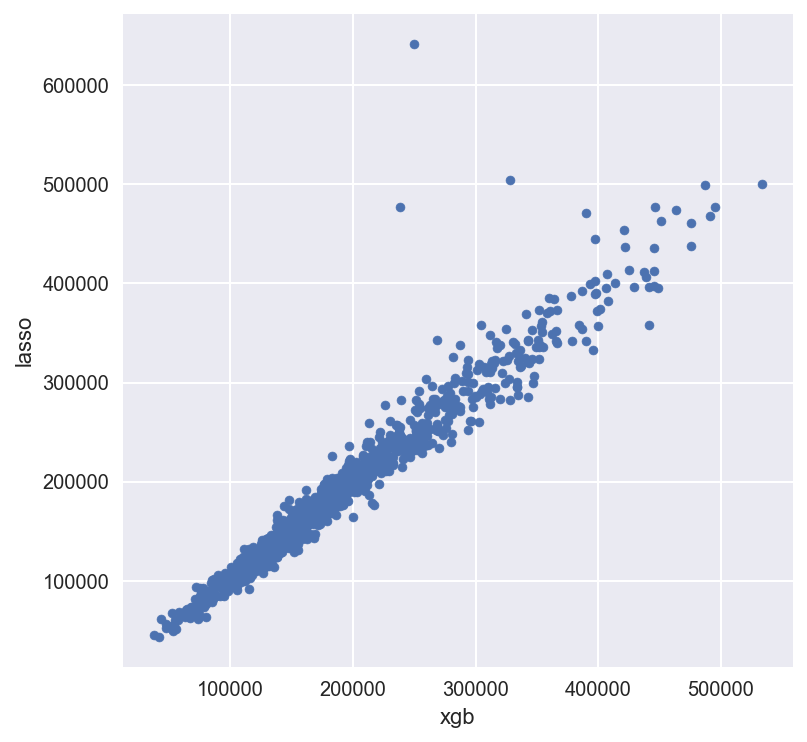

In [33]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")